<a href="https://colab.research.google.com/github/yvrjsharma/HugginFace_Gradio/blob/main/Using_HFHub_for_Image_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune any state-of-the-art Vision model like ConvNext for Image Classification
- Using Hugging Face Transformers Library + Pytorch 
- ConvNext is a new framework from Facebook which claims to outperform ViT, Swin Transformer etc. on Imagenet classifctaion task.
- We will be using [ImageFolder](https://huggingface.co/docs/datasets/image_process#imagefolder) method from Hub and show how it is useful in handling image data.
- You can load any custom image folder havng images from your machine, or any url for a zipped folder can also be used. This creates a huggingface dataset object.
- Once you have your image data as a HF dataset object you can do lots of fast operations like Map, Data Augmentation etc.

### Set-up environment

In [22]:
!pip install -q transformers datasets

### Loading Dataset
- Let's load [Eurosat dataset](https://github.com/phelber/EuroSAT) which is a collection of 27000 images taken from satellites (Sentinels) and is diviided into 10 classes based on land use like forest, river, highwasys, temperate forest, industrial land etc. So thi is a multi-class classification problem.
- Lets load the dataset as HF dataset first and then puch to HF.

In [2]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_files="https://madm.dfki.de/files/sentinel/EuroSAT.zip")

Using custom data configuration default-0537267e6f812d56


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-0537267e6f812d56/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

- Inspecting dataset

In [4]:
dataset #prints a datset dictionary

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

In [5]:
dataset["train"]  #gives you actual HF dataset object with two columns

Dataset({
    features: ['image', 'label'],
    num_rows: 27000
})

- Here we have two columns in our dataset - Image and label
- Image column is of type Image, which is nothing but a feature in HF dataset library
- Label column is of type ClassLabel

In [6]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

- Lets get the name of classes from Label column

In [7]:
labels = dataset["train"].features["label"].names
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


- Lets get the idea of type of images present inside the dataset. We will use cool feature of HF dataset which allows us to display images right here in the notebook -

In [8]:
example = dataset["train"][0] #getting first element from the dataset  
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7FA2DB26F610>,
 'label': 0}

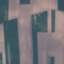

In [9]:
example["image"]  #how cool is that!!

In [10]:
example["label"] #gives you id

0

- Lets create a mapping of these label ids to label names 

In [13]:
id2label = {k:v for k,v in enumerate(labels)}
print(id2label)
print(id2label[0])  #gives you the correct class for id 0

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
AnnualCrop


- Lets create a reverse mapping of class label names to ids too

In [14]:
label2id = {v:k for k,v in enumerate(labels)}
label2id

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

- **Pushing the Dataset to hub**

In [16]:
from huggingface_hub import notebook_login

notebook_login()


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [17]:
dataset.push_to_hub("ysharma/eurosat-demo")

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

- Uploading our dataset to Hub helps in reloading the dataset easily and wherever we want like shown in below example -
```
from datasets import load_dataset
reloaded_dataset = load_dataset("ysharma/eurosat-demo")
```
- This is a cool feature which can allow us to share our dataset with anyone we want to.

### ConvNext model
- Can be accessed from Hub [here](https://huggingface.co/docs/transformers/main/en/model_doc/convnext#convnext) 
- convnext is a image classification model and is inspired by resnet and swin transformer
- Every vision model on hub has feature called FeatureExtractor. Its function is to prepare images for the model for inference. Its vital for using a vision model to knoww how you can prepare images for it.
- convnext feature extractor would help with resizing the imege, normalizing pixel values and so on.
- Next, we have to decide on the checkpoint of the model that we would want to use for our task. Lets look on the Hub again for this. For the purpose of this notebook we are going ahead with convnext tiny model - [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224), checkpoint from the hub.
- We will start by loading the corresponding feature extractor

In [19]:
from transformers import ConvNextFeatureExtractor

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224") #this loads the corresponding preprocessor config from - https://huggingface.co/facebook/convnext-tiny-224/blob/main/preprocessor_config.json

- Lets look at the config just loaded and observe details like
  - image size expected is 224 (cross 224)
  - mean and std dev for the images that will be used for the images passed onto model

In [20]:
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



**Data Processing**
- Performing data augmentation using [torchvision](https://pytorch.org/vision/stable/transforms.html) package from pytorch. You may want to use Albumentations or imgaug too if you want 
- Resizing, flipping of images comes under augmentation. This is done primarily to make our vision model more robust in its predictions



In [28]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor
)

#normalizing the image pixel values using preprocessor config from above
#so we will be using imagenet means and std dev that is coming up with the mode
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

#Definning all transformation here as a list 
transform = Compose(
    [
     RandomResizedCrop(feature_extractor.size), 
     RandomHorizontalFlip(),
     ToTensor(), #as images are coming in as Pillow object
     normalize
    ]
)

- Defining a custom function that we can apply to entire HF dataset

In [26]:
#input is dictionary of examples from HF dataset
def train_transforms(examples):
  #adding new column to dataset
  examples["pixel_values"] = [transform(image.convert('RGB')) for image in examples["image"]]

  #returning examples dictionary 
  return examples

- Applying these transformations on entire dataset in example batches of 1000

In [33]:
transformed_dataset = dataset.map(train_transforms, batched=True)

  0%|          | 0/27 [00:00<?, ?ba/s]

- We can either apply on entire dataset like above or apply our transformations on the fly. On the fly would mean applying transformations only while passing the images to model. This can be done using ``` with_transform ``` functionality of HF dataset.

In [30]:
processed_dataset = dataset.with_transform(train_transforms)

processed_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

In [31]:
processed_dataset["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 27000
})

- Performing image transformations defined above, on the fly or whenever you need them. Notice the new column pixel_values added to the processed dataset example

In [32]:
processed_dataset["train"][0]  

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7FA2C03EDB10>,
 'label': 0,
 'pixel_values': tensor([[[ 0.1768,  0.1768,  0.1768,  ..., -1.2788, -1.2788, -1.2788],
          [ 0.1768,  0.1768,  0.1768,  ..., -1.2788, -1.2788, -1.2788],
          [ 0.1768,  0.1768,  0.1768,  ..., -1.2788, -1.2788, -1.2788],
          ...,
          [-1.1418, -1.1418, -1.1418,  ...,  0.2624,  0.2624,  0.2624],
          [-1.1418, -1.1418, -1.1418,  ...,  0.2624,  0.2624,  0.2624],
          [-1.1418, -1.1418, -1.1418,  ...,  0.2624,  0.2624,  0.2624]],
 
         [[ 0.0476,  0.0476,  0.0476,  ..., -0.6702, -0.6702, -0.6702],
          [ 0.0476,  0.0476,  0.0476,  ..., -0.6702, -0.6702, -0.6702],
          [ 0.0476,  0.0476,  0.0476,  ..., -0.6702, -0.6702, -0.6702],
          ...,
          [-0.5651, -0.5651, -0.5651,  ...,  0.1352,  0.1352,  0.1352],
          [-0.5651, -0.5651, -0.5651,  ...,  0.1352,  0.1352,  0.1352],
          [-0.5651, -0.5651, -0.5651,  ...,  0.1352,  0

In [36]:
processed_dataset["train"][0]["pixel_values"].shape  #which will be passed on to the model

torch.Size([3, 224, 224])

### Defining the model
- Getting the model for fine-tuning using [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto) of Huggingface transformers library
- Auto Classes helps in making sure that based on your Hub model checkpoint provided you instantiate the correct classes
- For example here behind the scenes Auto Class will automatically instantiate the [ConvNextForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/convnext#transformers.ConvNextForImageClassification) class for us.

In [37]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224")
